# Planetesimal Formation
Pluto Jiang 2024

## Imports

In [60]:
import os
import json
import sys
# Add the path to the DiscEvolution directory
sys.path.append(os.path.abspath(os.path.join('..')) + '/DiscEvolution')

import numpy as np
import matplotlib.pyplot as plt

from constants import *
from grid import Grid
from star import SimpleStar
from eos import IrradiatedEOS, LocallyIsothermalEOS
from disc import *
from viscous_evolution import ViscousEvolution, ViscousEvolutionFV, LBP_Solution
from disc import AccretionDisc
from dust import *

## Config Parameters

In [61]:
config = {
    "grid": {
        "rmin": 0.1,
        "rmax": 1000,
        "nr": 1000,
        "spacing": "natural"
    },
    "simulation": {
        "t_initial": 0,
        "t_final": 1e6,
        "t_interval": [0, 0.1, 0.5, 1, 2], # Myr
    },
    "disc": {
        "alpha": 1e-3,
        "M": 0.05,
        "Rc": 35.0,
        "d2g": 0.01
    },
    "eos": {
        "type": "LocallyIsothermalEOS",
        "h0": 1/30,
        "q": -0.25
    },
    "transport": {
        "gas_transport": True,
        "radial_drift": True
    },
    "dust_growth": {
        "feedback": False,
        "settling": False,
        #"f_ice": 0,
        #"thresh": 1.,
        "f_ice": 1, # default 
        "thresh": 0.1, # default
    },
    "planetesimal": {
        "include_planetesimals": True,
        "diameter": 100  # km
    }
}

## Planetesimal Formation Simulation

Nstep: 0
Time: 0.0 yr


C:\Users\Queena\AppData\Local\Temp\ipykernel_3760\3329770017.py:147: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  l, = axes[0].loglog(grid.Rc, disc.Sigma_G / (AU*AU), label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)))
C:\Users\Queena\AppData\Local\Temp\ipykernel_3760\3329770017.py:177: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].set_ylim(ymin=1e-10, ymax=1e6)
C:\Users\Queena\AppData\Local\Temp\ipykernel_3760\3329770017.py:179: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[3].loglog(grid.Rc, disc.v_drift[0], linestyle="dotted", color=l.get_color())
C:\Users\Queena\AppData\Local\Temp\ipykernel_3760\3329770017.py:184: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[3].set_ylim(ymin=1e-15, ymax=1e-5)
c:\Users\Queena\Documents\DiscEvolution/DiscEvolution\dust.py:814: RuntimeWarning: divide by zero encountered in reciprocal
  l

Nstep: 2137
Time: 100000.0 yr
Nstep: 10685
Time: 500000.0 yr
Nstep: 21370
Time: 1000000.0 yr
Nstep: 42740
Time: 2000000.0 yr


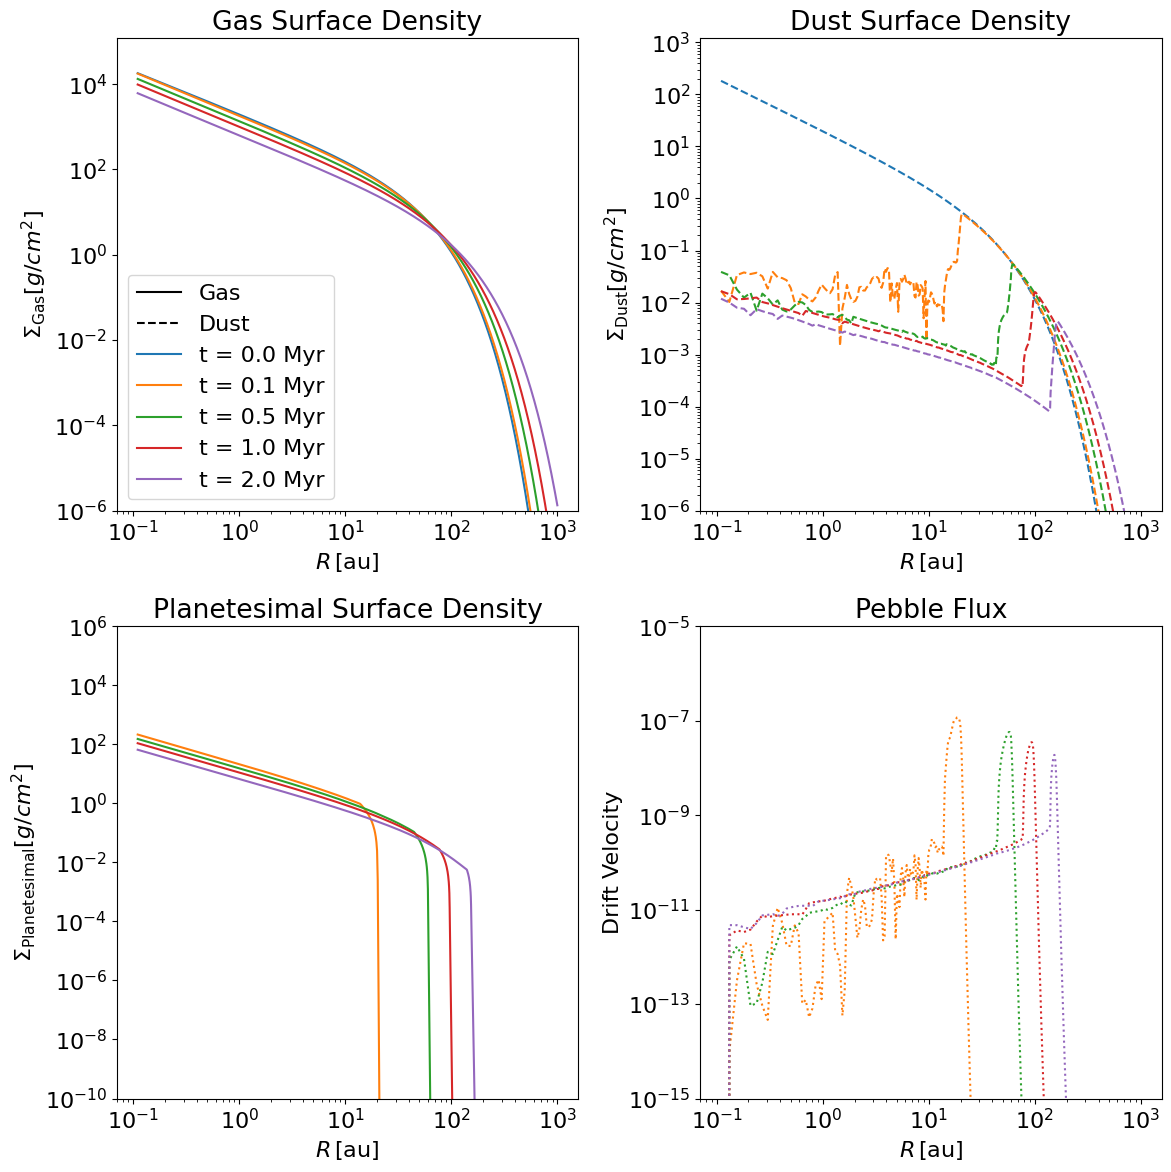

In [62]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def run_model(config):
    """
    Run the disk evolution model and plot the results.
    
    Parameters:
    config (dict): Configuration dictionary containing all parameters.
    """
    # Extract parameters from config
    grid_params = config['grid']
    sim_params = config['simulation']
    disc_params = config['disc']
    eos_params = config['eos']
    transport_params = config['transport']
    dust_growth_params = config['dust_growth']
    planetesimal_params = config['planetesimal']
    
    # Set up disc
    # ========================
    # Create the grid
    grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], grid_params['spacing'])

    # Create time array
    if sim_params['t_interval'] == "power":
        # Determine the number of points needed
        if sim_params['t_initial'] == 0:
            num_points = int(np.log10(sim_params['t_final'])) + 1
            times = np.logspace(0, np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(sim_params['t_final'] / sim_params['t_initial'])) + 1
            times = np.logspace(np.log10(sim_params['t_initial']), np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
    elif type(sim_params['t_interval']) == list:
        times = np.array(sim_params['t_interval']) * 2 * np.pi * 1e6
    else:
        times = np.arange(sim_params['t_initial'], sim_params['t_final'], sim_params['t_interval']) * 2 * np.pi
    
    # Create the star
    star = SimpleStar()
    
    # Create the EOS
    eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], disc_params['alpha'])
    eos.set_grid(grid)
    
    # Set up initial surface density according to Lenz
    nud = np.interp(disc_params['Rc'], grid.Rc, eos.nu)
    sol = LBP_Solution(disc_params['M'] * Msun, disc_params['Rc'], nud, 1)

    Sigma = sol(grid.Rc, 0.)

    eos.update(0, Sigma)

    # Set disc model
    if disc_params['d2g'] > 0:
        disc = DustGrowthTwoPop(grid, star, eos, disc_params['d2g'], Sigma=Sigma, f_ice=dust_growth_params['f_ice'], thresh=dust_growth_params['thresh'])
    else:
        disc = AccretionDisc(grid, star, eos, Sigma=Sigma)
    

    # Set up model
    # ========================
    # Set up dynamics
    if transport_params['gas_transport']:
        gas = ViscousEvolutionFV()
    if transport_params['radial_drift'] and disc_params['d2g'] > 0:
        dust = SingleFluidDrift(settling=dust_growth_params['settling'], planetesimal=planetesimal_params['include_planetesimals'])
    
    if planetesimal_params['include_planetesimals']:
        planetesimal = PlanetesimalFormation(disc)
        # Initialize a list to store non-zero M_peb values and corresponding times
        non_zero_M_peb = []
    
    # Run model
    # ========================
    t = 0
    n = 0
    
    # Prepare plots
    if planetesimal_params['include_planetesimals']:
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        axes = axes.flatten()
        axes[3].plot(grid.Rc, 0*grid.Rc, linestyle='dotted', color='black', label="Small dust")
        axes[3].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Large dust")
    elif transport_params['radial_drift']:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(figsize=(6, 6))
    
    # Set up initial plot lines
    try:
        axes[0].plot(grid.Rc, 0*grid.Rc, '-', color='black', label="Gas")
        axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Dust")
        #axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dotted", color='black', label="Small dust")
        #axes[0].plot(grid.Rc, 0*grid.Rc, linestyle="dashed", color='black', label="Large dust")
    except:
        pass
    
    for ti in times:
        while t < ti:
            if transport_params['gas_transport']:
                dt = gas.max_timestep(disc)
            if transport_params['radial_drift']:
                v_visc = gas.viscous_velocity(disc)
                dt = min(dt,dust.max_timestep(disc, v_visc))
            dt = min(dt, ti - t)
            
            # Do dust evolution
            if transport_params['radial_drift']:
                dust(dt, disc, v_visc=v_visc)
            
            # Do advection-diffusion update
            try:
                dust_frac = disc.dust_frac
            except AttributeError:
                dust_frac = None
            
            if transport_params['gas_transport']:
                gas(dt, disc, [dust_frac])
            
            # # Pin the values to >= 0 and <=1:
            disc.Sigma[:] = np.maximum(disc.Sigma, 0)        
            try:
                disc.dust_frac[:] = np.maximum(disc.dust_frac, 0)
                disc.dust_frac[:] /= np.maximum(disc.dust_frac.sum(0), 1.0)
            except AttributeError:
                pass
            
            if planetesimal_params['include_planetesimals']:
                planetesimal.update(dt, disc, dust)
                
            if planetesimal_params['include_planetesimals'] and np.sum(disc.M_peb) > 0:
                non_zero_M_peb.append((t, disc.M_peb.copy()))

            # Do grain growth
            disc.update(dt)
            
            t += dt
            n += 1

        print('Nstep: {}'.format(n))
        print('Time: {} yr'.format(t / (2 * np.pi)))
        
        if gas:
            try:
                l, = axes[0].loglog(grid.Rc, disc.Sigma_G / (AU*AU), label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)))
                axes[0].set_xlabel('$R\\,[\\mathrm{au}]$')
                axes[0].set_ylabel('$\\Sigma_{\\mathrm{Gas}} [g/cm^2]$')
                axes[0].set_ylim(ymin=1e-6)
                axes[0].set_title('Gas Surface Density')
                axes[0].legend()
            except:
                axes.loglog(grid.Rc, disc.Sigma_G / AU, label='t = {} yrs'.format(np.round(t / (2 * np.pi))))
                axes.set_xlabel('$R\\,[\\mathrm{au}]$')
                axes.set_ylabel('$\\Sigma_{\\mathrm{Gas}}$')
                #axes.set_ylim(ymin=1e-6, ymax=1e6)
                axes.set_title('Gas Surface Density')
                axes.legend()

        if transport_params['radial_drift']:
            #axes[1].loglog(grid.Rc, disc.Sigma_D[0] / (AU*AU), linestyle="dotted", color=l.get_color())
            #axes[1].loglog(grid.Rc, disc.Sigma_D[1] / (AU*AU), linestyle='dashed', color=l.get_color())
            axes[1].loglog(grid.Rc, (disc.Sigma_D[0]+disc.Sigma_D[1]) / (AU*AU), linestyle="dashed", color=l.get_color())

            axes[1].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[1].set_ylabel('$\\Sigma_{\\mathrm{Dust}} [g/cm^2]$')
            #axes[1].set_ylim(ymin=1e-6, ymax=1e6)
            axes[1].set_title('Dust Surface Density')
            axes[1].set_ylim(ymin=1e-6)
        
        if planetesimal_params['include_planetesimals']:
            axes[2].loglog(grid.Rc, disc.Sigma_D[2] / (AU*AU), '-', color=l.get_color())
            axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[2].set_ylabel('$\\Sigma_{\\mathrm{Planetesimal}} [g/cm^2]$')
            axes[2].set_title('Planetesimal Surface Density')
            axes[2].set_ylim(ymin=1e-10, ymax=1e6)
            
            axes[3].loglog(grid.Rc, disc.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[3].loglog(grid.Rc, disc.v_drift[1], linestyle='dashed', color=l.get_color())
            axes[3].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[3].set_ylabel('Drift Velocity')
            axes[3].set_title('Pebble Flux')
            axes[3].set_ylim(ymin=1e-15, ymax=1e-5)
        elif transport_params['radial_drift']:
            axes[2].plot(grid.Rc, 0*grid.Rc, label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6), 2)), color=l.get_color())
            axes[2].loglog(grid.Rc, disc.v_drift[0], linestyle="dotted", color=l.get_color())
            axes[2].loglog(grid.Rc, disc.v_drift[1], linestyle='dashed', color=l.get_color())

            axes[2].set_xlabel('$R\\,[\\mathrm{au}]$')
            axes[2].set_ylabel('Drift Velocity')
            axes[2].set_ylim(ymin=1e-6)
            axes[2].set_title('Drift Velocity')
            axes[2].legend()

    # if planetesimal_params['include_planetesimals']:
    #     for t, M_peb in non_zero_M_peb[::5000]:
    #         c, = axes[3].loglog(grid.Rc, 0*grid.Rc, label='t = {} Myr'.format(np.round(t / (2 * np.pi * 1e6))))
    #         axes[3].loglog(grid.Rc, M_peb[0], linestyle="dotted", color=c.get_color())
    #         axes[3].loglog(grid.Rc, M_peb[1], linestyle='dashed', color=c.get_color())
    #     axes[3].loglog(grid.Rc, disc.M_cr, linestyle="-", color='black', label="Critical flux")
    #     axes[3].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# With planetesimals
run_model(config)

# Without planetesimals
# config['planetesimal']['include_planetesimals'] = False
# run_model(config)

# # Without planetesimals and dust
# config['planetesimal']['include_planetesimals'] = False
# config['disc']['d2g'] = 0
# config['transport']['radial_drift'] = False
# run_model(config)